### Load packages

In [1]:
import scanpy as sc
import episcanpy.api as epi
import numpy as np
import anndata as ad
import random
import copy
import pandas as pd

/home/icb/anna.danese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/icb/anna.danese/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [4]:
# Load processed data
adata = ad.read('./integration_resubmission/small_dataset_merged_dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 11134 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
annot = []
index = 0
for n in adata.obs_names.tolist():
    if adata.obs['batchname'][index] == '10x Genomics':
        annot.append('10x Genomics')
    elif adata.obs['batchname'][index] == 'Fang et al.':
        annot.append(' - '.join(['Fang et al.', adata.obs['batchname_Fang'][index]]))
        
    elif adata.obs['batchname'][index] == 'Cusanovich et al.':
        annot.append(' - '.join(['Cusanovich et al.', 'WholeBrainA_62216']))

    else:
        annot.append(n)
    index += 1
    
adata.obs['batchname_all'] = annot

In [12]:
set(adata.obs['batchname_all'])

{'10x Genomics',
 'Cusanovich et al. - WholeBrainA_62216',
 'Fang et al. - CEMBA180305_2B'}

In [13]:
adata

AnnData object with n_obs × n_vars = 11134 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
# Load reference dataset for cell label transfer
adata_large = ad.read('./integration_resubmission/large_peaks_dataset_merged_dataset_cell_label.h5ad')
adata_large

AnnData object with n_obs × n_vars = 84814 × 96924 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features', 'batch', 'batchname_Fang', 'batchname', 'batchname_Cusanovich', 'n_counts', 'batchname_all', 'final_cell_label'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_all_colors', 'batchname_colors', 'final_cell_label_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

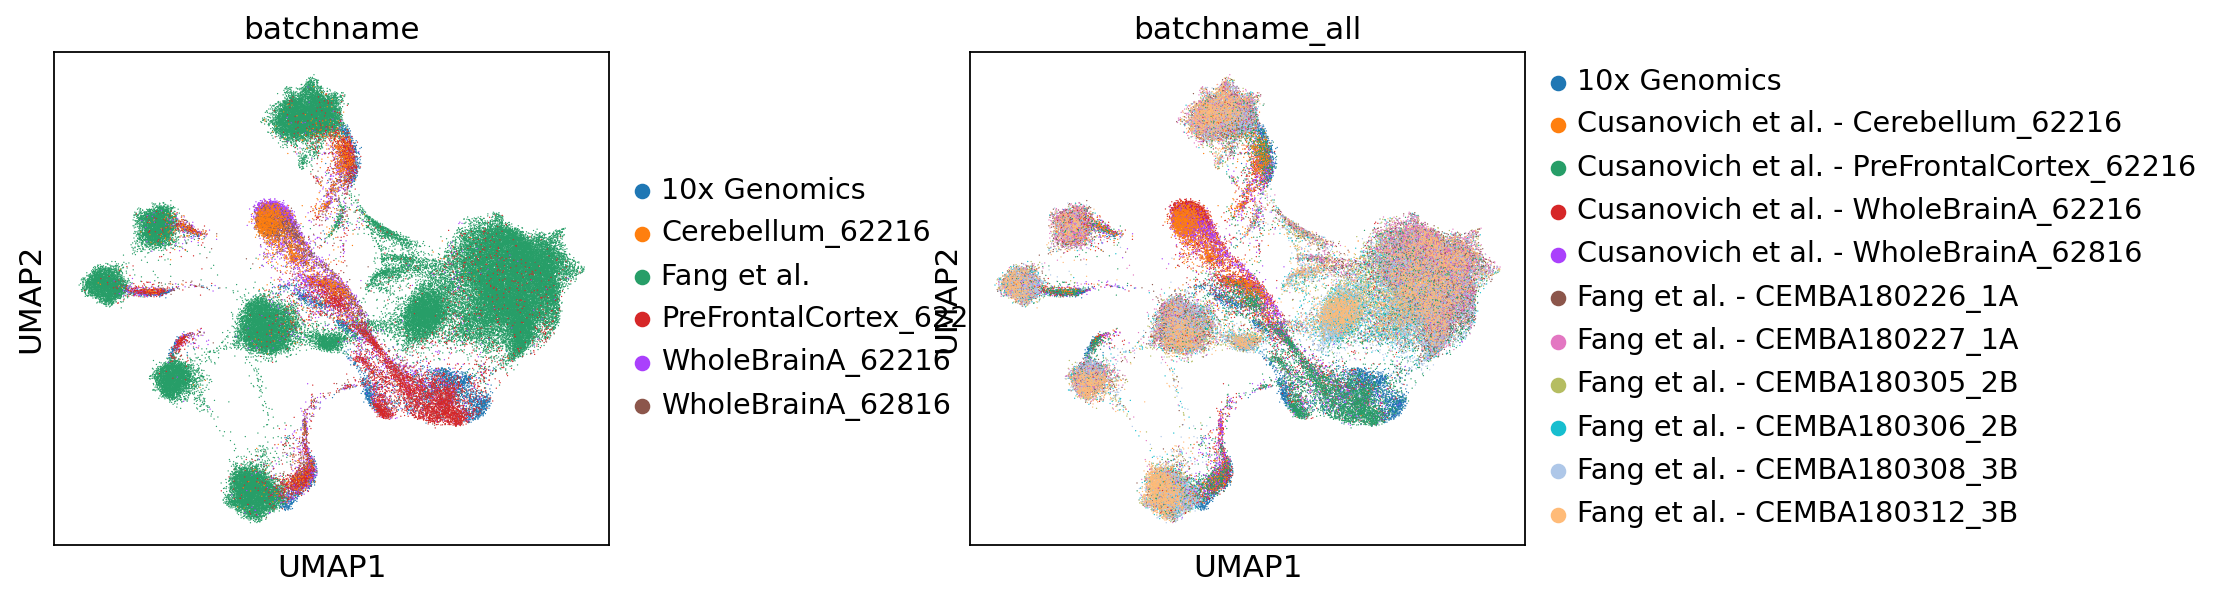

In [15]:
sc.pl.umap(adata_large, color=['batchname', 'batchname_all'], wspace=0.5)

... storing 'batchname_all' as categorical
... storing 'annot_10x' as categorical


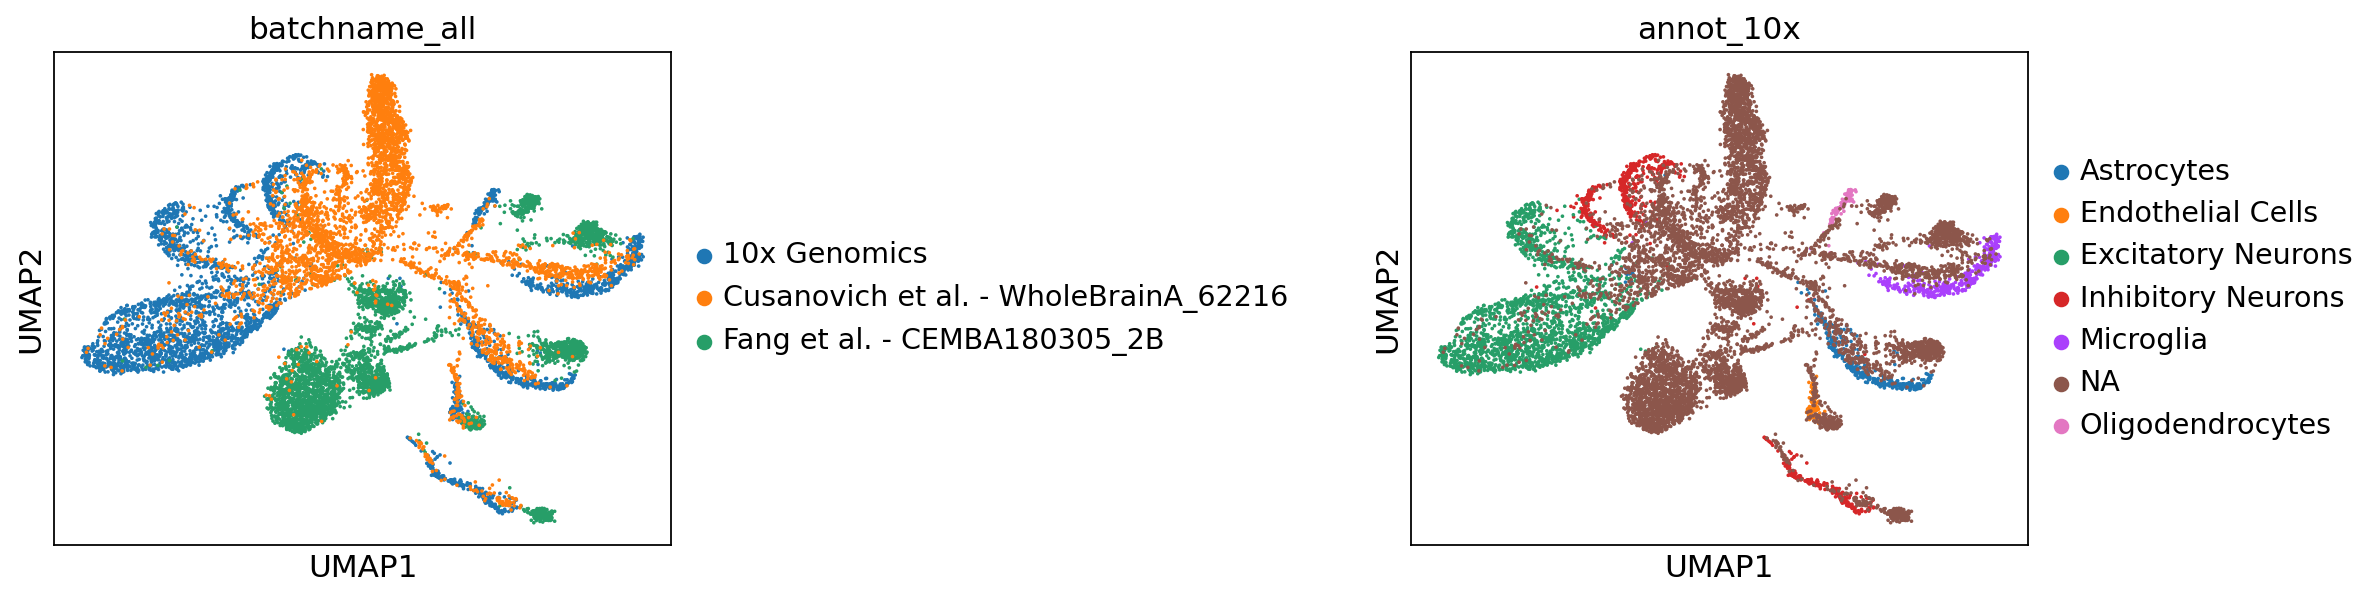

In [16]:
index = 0
annot_10x = {}
for cell in adata_large.obs_names.tolist():
    if adata_large.obs['batchname_all'][index] == '10x Genomics':
        annot_10x[cell] = adata_large.obs['final_cell_label'][index]
    index += 1

annot = []
for cell in adata.obs_names.tolist():
    if cell in annot_10x.keys():
        annot.append(annot_10x[cell])
    else:
        annot.append('NA')
adata.obs['annot_10x'] = annot 

sc.pl.umap(adata, color=['batchname_all', 'annot_10x'], wspace=1)

... storing 'annot_fang3' as categorical


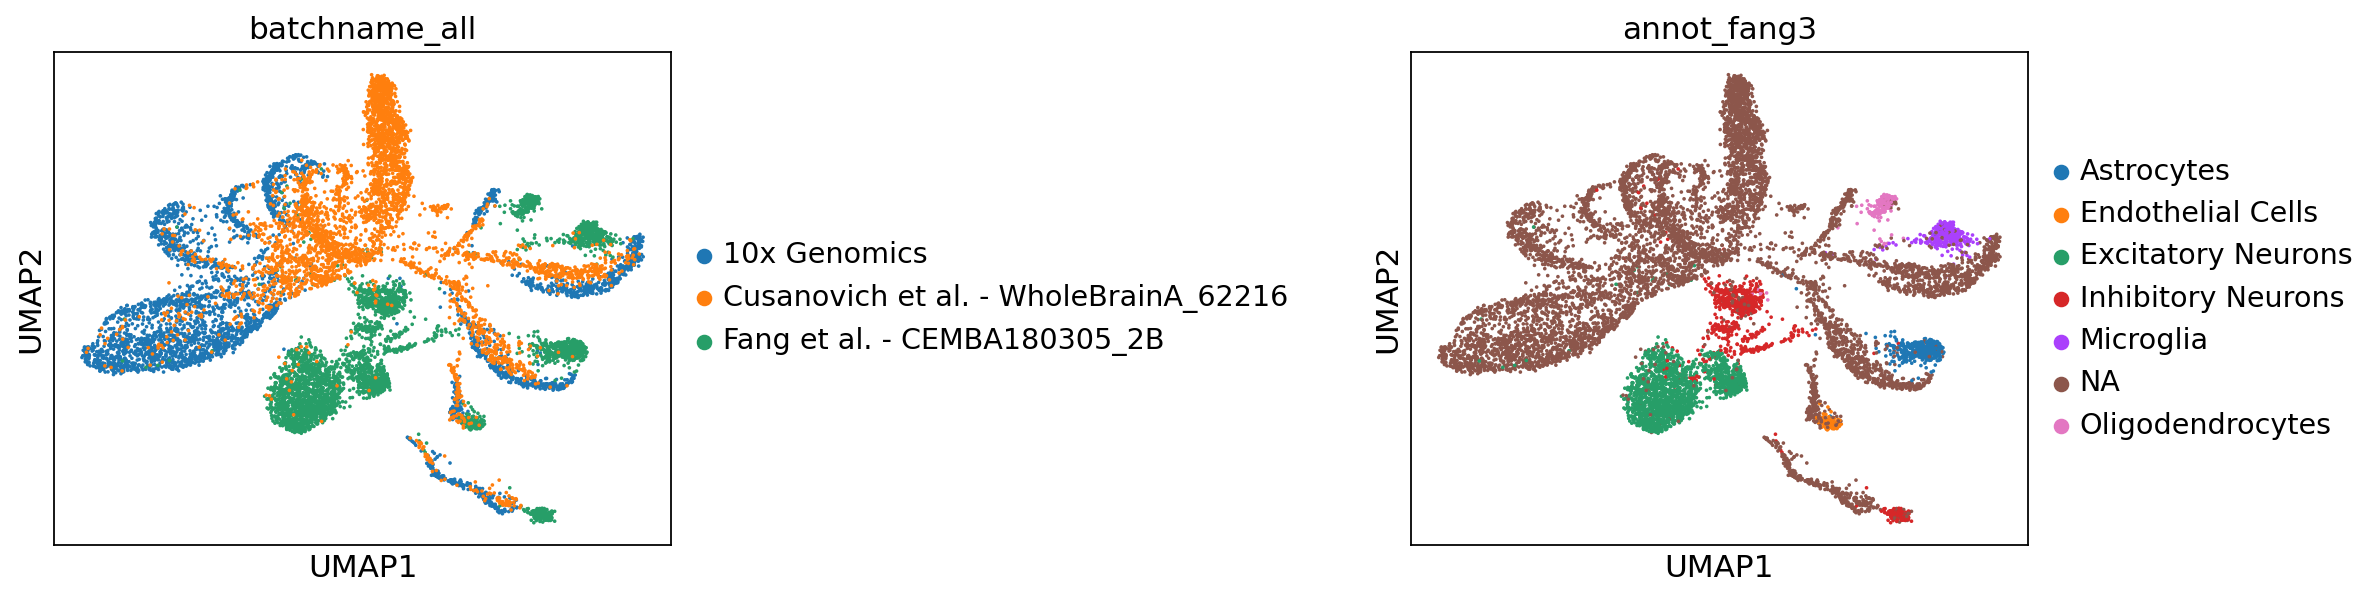

In [32]:
index = 0
annot_fang = {}
for cell in adata_large.obs_names.tolist():
    if adata_large.obs['batchname_all'][index] == 'Fang et al. - CEMBA180305_2B':
        annot_fang[cell.split('-')[0]] = adata_large.obs['final_cell_label'][index]
    index += 1

annot = []
index = 0
for cell in adata.obs_names.tolist():
    if adata.obs['batchname_all'][index] == 'Fang et al. - CEMBA180305_2B':
        if cell.split('-')[0] in annot_fang.keys():
            annot.append(annot_fang[cell.split('-')[0]])
        else:
            annot.append('NA')
    else:
        annot.append('NA')
    index += 1
adata.obs['annot_fang3'] = annot 

sc.pl.umap(adata, color=['batchname_all', 'annot_fang3'], wspace=1)

... storing 'annot_cus3' as categorical


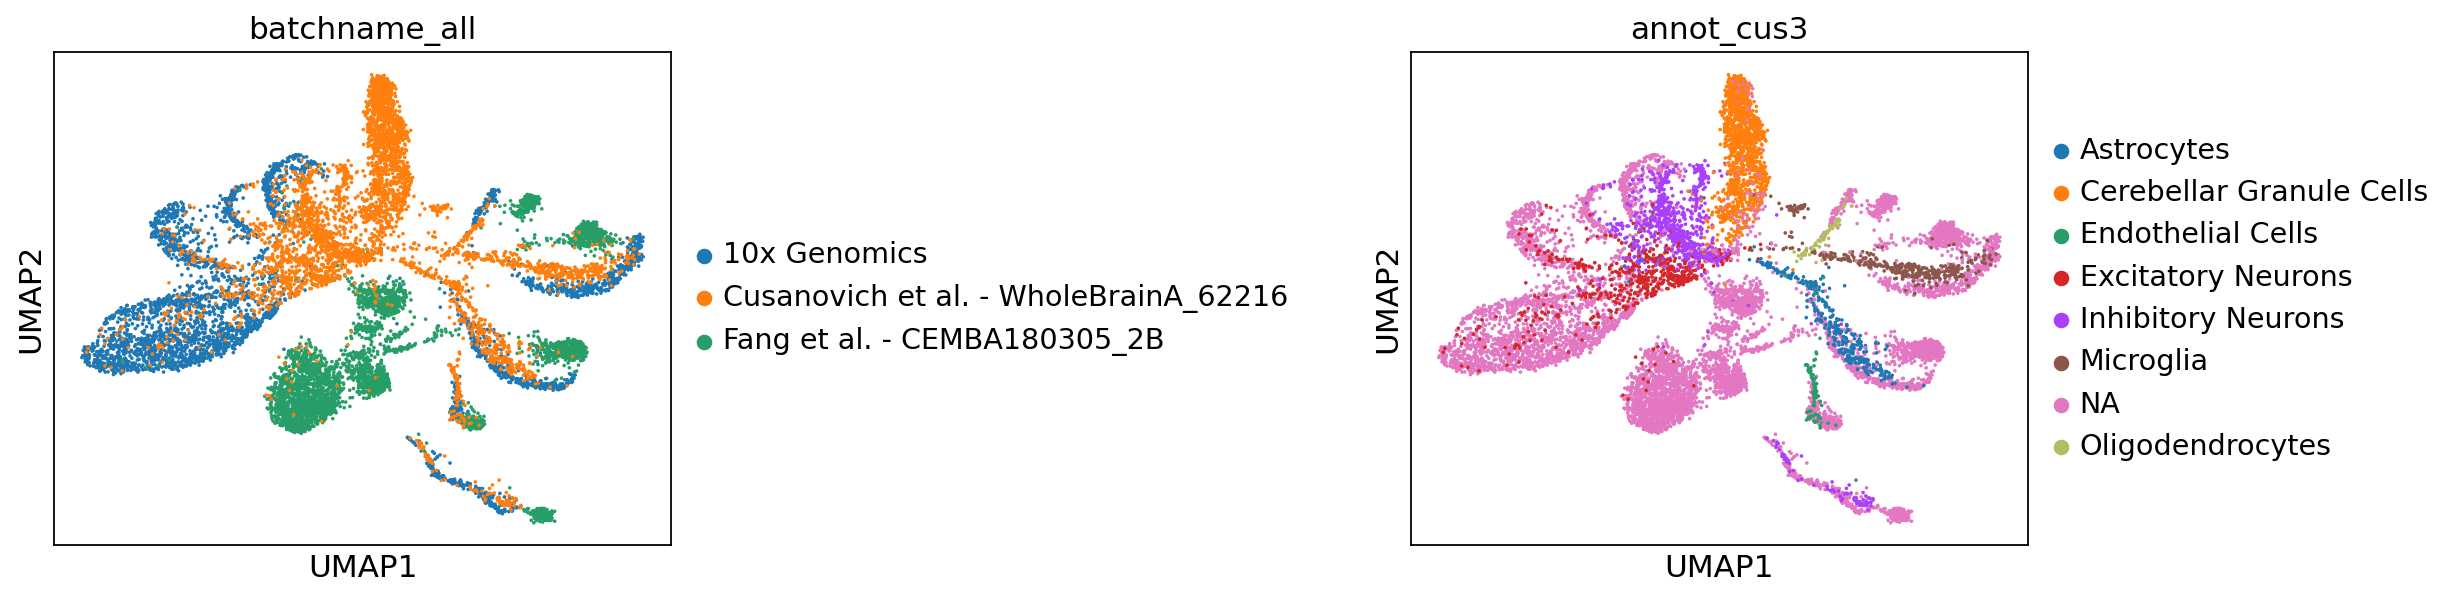

In [26]:
index = 0
annot_cus = {}
for cell in adata_large.obs_names.tolist():
    if adata_large.obs['batchname_all'][index] == 'Cusanovich et al. - WholeBrainA_62216':
        annot_cus[cell.split('-')[0]] = adata_large.obs['final_cell_label'][index]
    index += 1

annot = []
index = 0
for cell in adata.obs_names.tolist():
    if adata.obs['batchname_all'][index] == 'Cusanovich et al. - WholeBrainA_62216':
        if cell.split('-')[0] in annot_cus.keys():
            annot.append(annot_cus[cell.split('-')[0]])
        else:
            annot.append('NA')
    else:
        annot.append('NA')
    index += 1
adata.obs['annot_cus3'] = annot 

sc.pl.umap(adata, color=['batchname_all', 'annot_cus3'], wspace=1)

In [28]:
adata

AnnData object with n_obs × n_vars = 11134 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts', 'annot_10x', 'annot_fang', 'annot_fang2', 'annot_fang3', 'annot_fang4', 'annot_fang5', 'annot_fang6', 'annot_cus', 'annot_cus2', 'annot_cus3', 'annot_cus4'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap', 'batchname_all_colors', 'annot_10x_colors', 'annot_fang_colors', 'annot_fang2_colors', 'annot_fang3_colors', 'annot_fang4_colors', 'annot_fang5_colors', 'annot_fang6_colors', 'annot_cus_colors', 'annot_cus2_colors', 'annot_cus3_colors', 'annot_cus4_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [34]:
set(annot)

{'Astrocytes',
 'Cerebellar Granule Cells',
 'Endothelial Cells',
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Microglia',
 'NA',
 'Oligodendrocytes'}

In [35]:
pd.crosstab(adata.obs['batchname_all'], adata.obs['all_cell_annot'])

all_cell_annot,Astrocytes,Cerebellar Granule Cells,Endothelial Cells,Excitatory Neurons,Inhibitory Neurons,Microglia,NA,Oligodendrocytes
batchname_all,,,,,,,,
10x Genomics,357,0,81,2038,669,420,0,102
Cusanovich et al. - WholeBrainA_62216,321,1245,80,536,890,416,236,63
Fang et al. - CEMBA180305_2B,395,0,101,1767,799,305,137,176


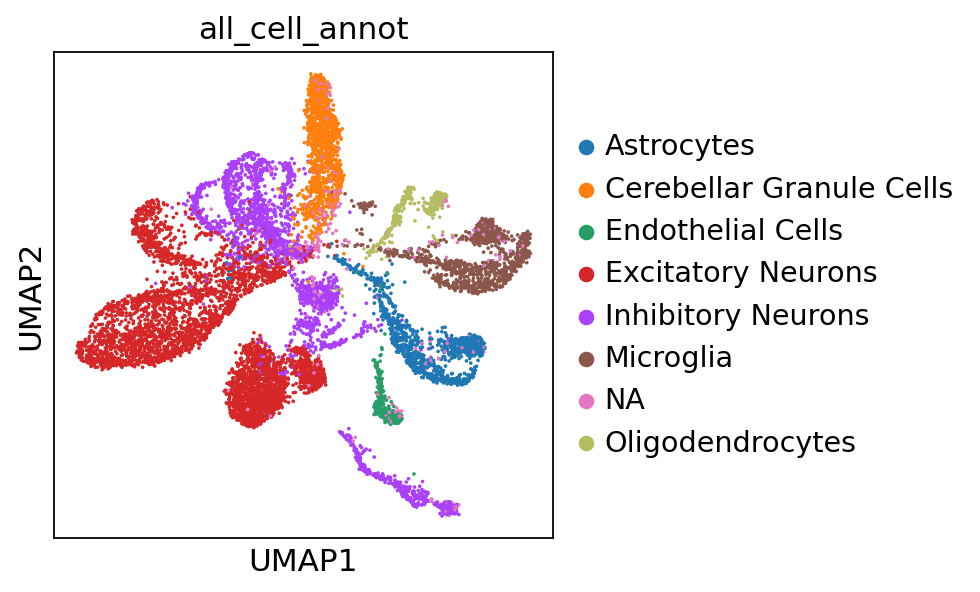

In [36]:
sc.pl.umap(adata, color=['all_cell_annot'])

In [37]:
adata

AnnData object with n_obs × n_vars = 11134 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts', 'annot_10x', 'annot_fang', 'annot_fang2', 'annot_fang3', 'annot_fang4', 'annot_fang5', 'annot_fang6', 'annot_cus', 'annot_cus2', 'annot_cus3', 'annot_cus4', 'all_cell_annot'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap', 'batchname_all_colors', 'annot_10x_colors', 'annot_fang_colors', 'annot_fang2_colors', 'annot_fang3_colors', 'annot_fang4_colors', 'annot_fang5_colors', 'annot_fang6_colors', 'annot_cus_colors', 'annot_cus2_colors', 'annot_cus3_colors', 'annot_cus4_colors', 'all_cell_annot_colors'
    obsm: 

In [38]:
adata = adata[adata.obs['all_cell_annot']!='NA',:].copy()
adata

AnnData object with n_obs × n_vars = 10761 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts', 'annot_10x', 'annot_fang', 'annot_fang2', 'annot_fang3', 'annot_fang4', 'annot_fang5', 'annot_fang6', 'annot_cus', 'annot_cus2', 'annot_cus3', 'annot_cus4', 'all_cell_annot'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap', 'batchname_all_colors', 'annot_10x_colors', 'annot_fang_colors', 'annot_fang2_colors', 'annot_fang3_colors', 'annot_fang4_colors', 'annot_fang5_colors', 'annot_fang6_colors', 'annot_cus_colors', 'annot_cus2_colors', 'annot_cus3_colors', 'annot_cus4_colors', 'all_cell_annot_colors'
    obsm: 

In [39]:
adata.obs['final_cell_label'] = adata.obs['all_cell_annot'].copy()

In [40]:
del adata.obs['annot_10x'], adata.obs['annot_fang'], adata.obs['annot_fang2'], adata.obs['annot_fang3']
del adata.obs['annot_fang4'], adata.obs['annot_fang5'], adata.obs['annot_fang6'], adata.obs['annot_cus']
del adata.obs['annot_cus2'], adata.obs['annot_cus3'], adata.obs['annot_cus4'], adata.obs['all_cell_annot']

del adata.uns['annot_10x_colors'], adata.uns['annot_fang_colors'], adata.uns['annot_fang2_colors'], adata.uns['annot_fang3_colors']
del adata.uns['annot_fang4_colors'], adata.uns['annot_fang5_colors'], adata.uns['annot_fang6_colors'], adata.uns['annot_cus_colors']
del adata.uns['annot_cus2_colors'], adata.uns['annot_cus3_colors'], adata.uns['annot_cus4_colors'], adata.uns['all_cell_annot_colors']

In [41]:
adata

AnnData object with n_obs × n_vars = 10761 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname_all', 'n_counts', 'final_cell_label'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'batchname_colors', 'neighbors', 'pca', 'umap', 'batchname_all_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [42]:
epi.pp.lazy(adata)

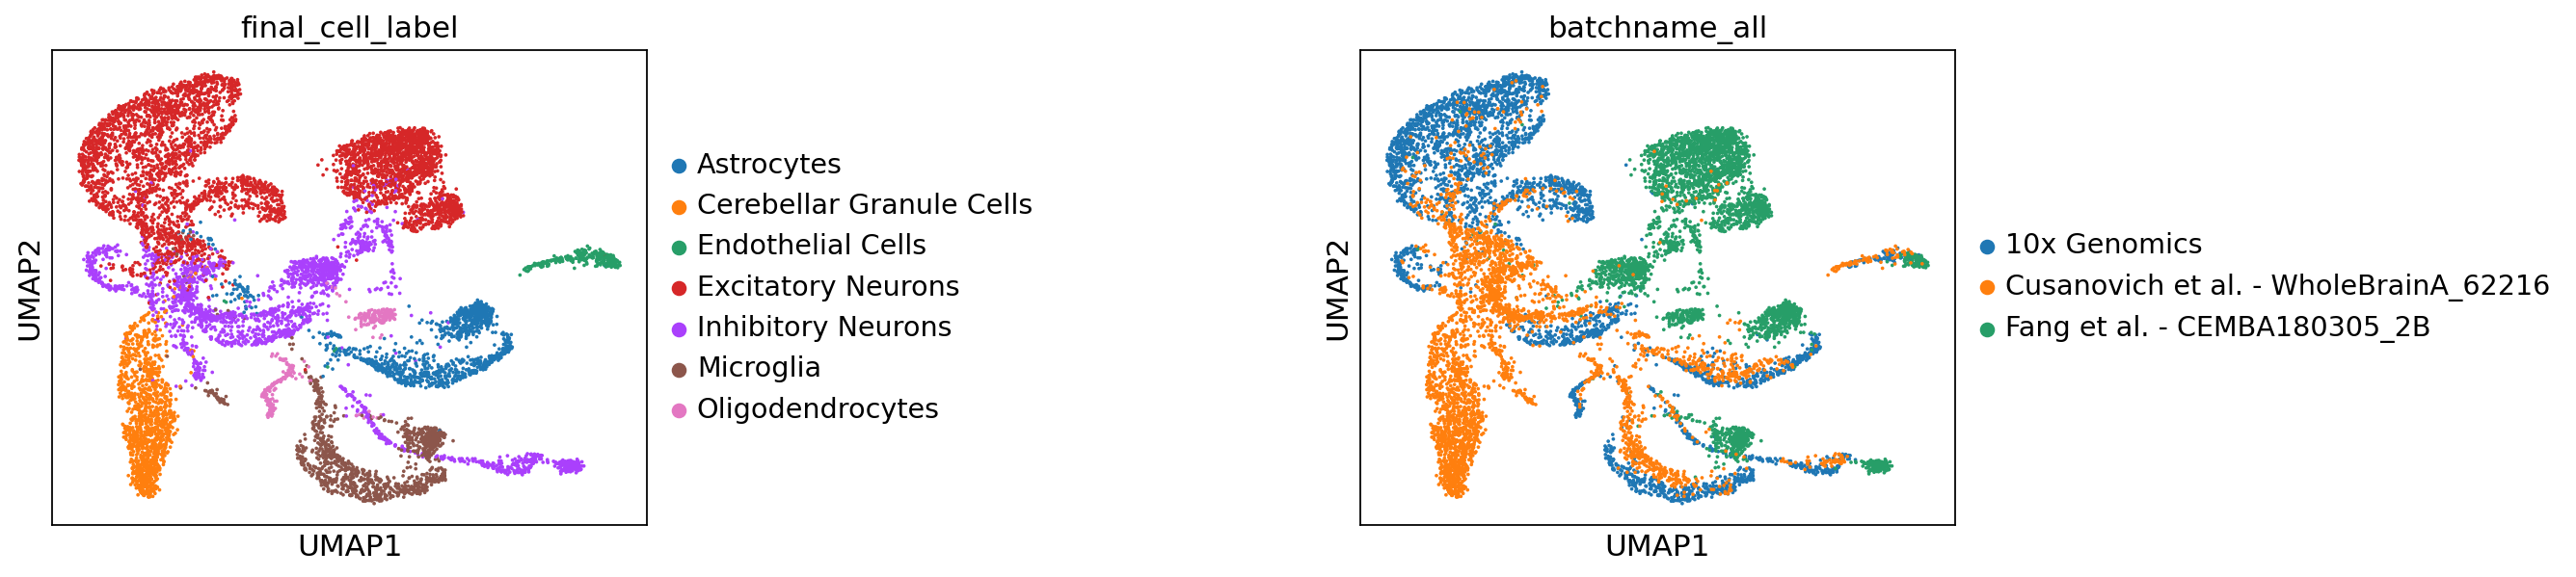

In [43]:
sc.pl.umap(adata, color=['final_cell_label', 'batchname_all'], wspace=1, save='small_windows.png')

In [44]:
adata.write('./integration_resubmission/small_dataset_merged_dataset_cell_label.h5ad')